### Reading data

The data for this project is located in [this hugging face space](https://huggingface.co/datasets/Jensen-holm/statcast-era-pitches) that I made. It contains every single pitch from the modern statcast era up through last year (2015-2023).

In [1]:
import polars as pl

STATCAST_ERA_PITCHES_URL: str = (
    "https://huggingface.co/api/datasets/Jensen-holm/statcast-era-pitches/parquet/default/train/0.parquet"
)

statcast_era_df: pl.DataFrame = pl.read_parquet(STATCAST_ERA_PITCHES_URL)
print(statcast_era_df.sample(3))

shape: (3, 92)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ pitch_typ ┆ game_date ┆ release_s ┆ release_p ┆ … ┆ of_fieldi ┆ spin_axis ┆ delta_hom ┆ delta_ru │
│ e         ┆ ---       ┆ peed      ┆ os_x      ┆   ┆ ng_alignm ┆ ---       ┆ e_win_exp ┆ n_exp    │
│ ---       ┆ str       ┆ ---       ┆ ---       ┆   ┆ ent       ┆ f32       ┆ ---       ┆ ---      │
│ str       ┆           ┆ f32       ┆ f32       ┆   ┆ ---       ┆           ┆ f32       ┆ f32      │
│           ┆           ┆           ┆           ┆   ┆ str       ┆           ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ FF        ┆ 2021-07-2 ┆ 91.5      ┆ 1.97      ┆ … ┆ Standard  ┆ 140.0     ┆ -0.017    ┆ 0.873    │
│           ┆ 7 00:00:0 ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│           ┆ 0.0000000 ┆           ┆           ┆   ┆           ┆           

# Pre-Processing

***Goal***
Reverse the magnus effect on the baseball for each pitch so that we can estimate where the ball would have ended up without spin induced magnus force. This will allow us to measure how well hte pitcher is tunneling their pitches because if two pitches end up in similar positions without spin, but end up far apart, the pitch was pretty elusive and was in likley appeared to like the other pitch.

In [2]:
# remove rows where columns we are interested in are null
TUNNEL_COLS: list[str] = [
    "pitch_type",  # type of pitch: FF, FC, CU, etc ...
    "release_pos_x",  # horizontal release position of ball in ft from catcher pov
    "release_pos_z",  # vertical release position of ball in ft from catcher pov
    "spin_axis",  # spin axis in clock format
    "pfx_x",  # horizontal movement in ft from catchers perspective
    "pfx_z",  # vertical movement in ft from catchers perspective
    "plate_x",  # horizontal position of ball when it crossed the plate
    "plate_z",  # vertical position of the ball when it crossed the plate
]

# drop missing values for the columns that we care about
statcast_era_pitches = statcast_era_df.drop_nulls(subset=TUNNEL_COLS)

In [3]:
# convert spin axis from clock format into degree format
def clock_to_deg(spin_axis: int) -> float:
    hours = spin_axis // 100
    minutes = spin_axis % 100
    return (hours * 30) + (minutes * 0.5)


statcast_era_df_mod = statcast_era_df.with_columns(
    pl.col("spin_axis")
    .map_elements(clock_to_deg, return_dtype=pl.Float32)
    .alias("spin_axis_deg"),
).rename({"spin_axis": "spin_axis_clk"})

print(statcast_era_df_mod.select("spin_axis_deg").sample(5, seed=42))

shape: (5, 1)
┌───────────────┐
│ spin_axis_deg │
│ ---           │
│ f32           │
╞═══════════════╡
│ 46.5          │
│ 35.5          │
│ 46.0          │
│ 83.5          │
│ 74.0          │
└───────────────┘


## Applying Magnus Equations

The goal of applying the magnus equations in this context will be to figure out where the ball would have ended up in the strike zone if the ball did not have any spin. This is useful because if two pitches end up in the same spot without spin, but ended up in very different places in reality, these pitches 'looked' like one another, and are a very good combo.

In [4]:
from dataclasses import dataclass
import numpy as np

# Magnus Formula Source:
# https://www.physicsforums.com/threads/magnus-effect-what-is-the-correct-formula.894467/#:~:text=The%20correct%20formula%20for%20calculating,sectional%20area%20of%20the%20object.

# Other source for coefficients & constants:
# https://www1.grc.nasa.gov/beginners-guide-to-aeronautics/aerodynamics-of-baseball/


@dataclass
class BaseballForce:
    _ball_radius: float = 1.43  # inches
    _air_density: float = 1.293  # kg/m^3
    _baseball_cd: float = 0.3  # drag coefficient of a baseball
    _ball_cross_sectional_area: float = np.pi * (0.07468 / 2) ** 2
    _baseball_mass: float = 0.145  # kg
    _g: float = 9.81  # gravitational constant

    @staticmethod
    def _angular_velocity(rpm: float) -> float:
        return (rpm * (2 * np.pi)) / 60

    def _magnus_effect(self, velocity: float, rpm: float) -> float:
        A = self._angular_velocity(rpm=rpm)
        return self._air_density * velocity * A * self._ball_cross_sectional_area

    def spin_force(self, velocity: float, spin_rpm: float, spin_axis: float) -> float:
        F = self._magnus_effect(velocity=velocity, rpm=spin_rpm)
        return (
            F * np.sin(np.radians(spin_axis)),  # horizontal movement caused by spin
            F * np.cos(np.radians(spin_axis)),  # vertical movement caused by spin
        )

    def air_resistance(self, velocity: float) -> float:
        return (
            0.5
            * self._air_density
            * (velocity**2)
            * self._ball_cross_sectional_area
            * self._baseball_cd
        )

    def gravitational_force(self) -> float:
        return self._g * self._baseball_mass

    def total_force(self, velocity: float, spin_rpm: float, spin_axis: float) -> float:
        h_spin_force, v_spin_force = self.spin_force(
            spin_axis=spin_axis, spin_rpm=spin_rpm, velocity=velocity
        )
        return (
            h_spin_force
            + v_spin_force
            + self.air_resistance(velocity=velocity)
            + self.gravitational_force()
        )

In [5]:
# add magnus force columns to our dataframe
ball_force_eqs = BaseballForce()

statcast_era_force_df: pl.DataFrame = statcast_era_df_mod.with_columns(
    h_magnus_force=ball_force_eqs.spin_force(
        velocity=pl.col("release_speed"),
        spin_axis=pl.col("spin_axis_deg"),
        spin_rpm=pl.col("release_spin_rate"),
    )[0],
    v_magnus_force=ball_force_eqs.spin_force(
        velocity=pl.col("release_speed"),
        spin_axis=pl.col("spin_axis_deg"),
        spin_rpm=pl.col("release_spin_rate"),
    )[1],
    air_resistance_force=ball_force_eqs.air_resistance(
        velocity=pl.col("release_speed"),
    ),
    gravitational_force=ball_force_eqs.gravitational_force(),
).with_columns(
    total_force=pl.col("h_magnus_force")
    + pl.col("v_magnus_force")
    + pl.col("air_resistance_force")
    + pl.col("gravitational_force")
)

print(
    statcast_era_force_df.select(
        "pitch_type",
        "release_speed",
        "h_magnus_force",
        "v_magnus_force",
        "air_resistance_force",
        "gravitational_force",
        "total_force",
    ).sample(5, seed=42)
)

shape: (5, 7)
┌────────────┬──────────────┬──────────────┬─────────────┬─────────────┬─────────────┬─────────────┐
│ pitch_type ┆ release_spee ┆ h_magnus_for ┆ v_magnus_fo ┆ air_resista ┆ gravitation ┆ total_force │
│ ---        ┆ d            ┆ ce           ┆ rce         ┆ nce_force   ┆ al_force    ┆ ---         │
│ str        ┆ ---          ┆ ---          ┆ ---         ┆ ---         ┆ ---         ┆ f64         │
│            ┆ f32          ┆ f64          ┆ f64         ┆ f32         ┆ f64         ┆             │
╞════════════╪══════════════╪══════════════╪═════════════╪═════════════╪═════════════╪═════════════╡
│ SL         ┆ 86.800003    ┆ 77.000973    ┆ 73.071196   ┆ 6.400705    ┆ 1.42245     ┆ 157.895324  │
│ SL         ┆ 86.300003    ┆ 76.268838    ┆ 106.924967  ┆ 6.327176    ┆ 1.42245     ┆ 190.943431  │
│ SL         ┆ 84.199997    ┆ 74.252706    ┆ 71.705009   ┆ 6.022995    ┆ 1.42245     ┆ 153.40316   │
│ FS         ┆ 91.199997    ┆ 90.986446    ┆ 10.366599   ┆ 7.066071    ┆ 1.42

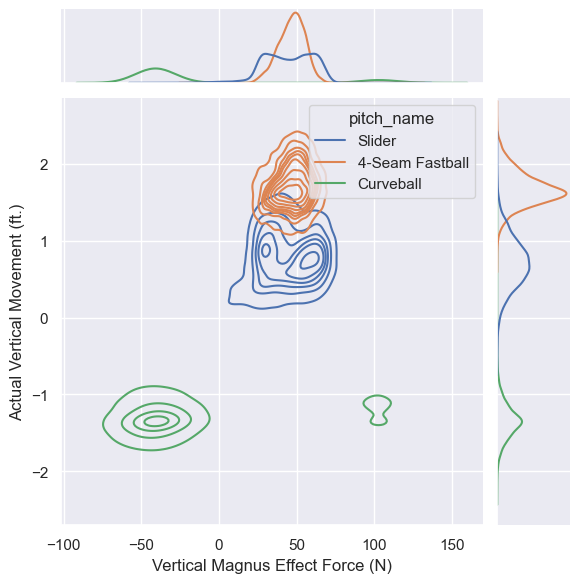

In [41]:
import seaborn as sns
import pybaseball
import matplotlib.pyplot as plt

sns.set_theme()

kershaw_mlbam_id = pybaseball.playerid_lookup(
    first="Clayton",
    last="Kershaw",
)["key_mlbam"]

rhp_v_force_fig = sns.jointplot(
    statcast_era_force_df.filter(
        pl.col("pitch_type").is_in(["FF", "SL", "CU"]),
        pl.col("pitcher") == kershaw_mlbam_id,
    ).to_pandas(),
    x="v_magnus_force", # vertical magnus force applied (N)
    y="pfx_z", # actual vertical movement (ft)
    hue="pitch_name",
    kind="kde",
)

rhp_v_force_fig.set_axis_labels(
    xlabel="Vertical Magnus Effect Force (N)",
    ylabel="Actual Vertical Movement (ft.)",
)

plt.show()